## Imports Libraries

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

np.random.seed(44)
tf.random.set_seed(44)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##1. Read the parser.txt file containing the image id and the respective word for that image and take the first 10000 instances for training and testing of the model

In [ ]:
f = open('/content/drive/MyDrive/ColabNotebooks/MidProj2/parser.txt', 'r') # Reading the Text file to data variable
line_data = f.readlines()
f.close()
data_lines = []
for line in line_data:
    if line.split(" ")[1] =="ok":  # We don't need to deal with errored entries.
        data_lines.append(line)

len(data_lines)

96456

In [ ]:
data_lmt = data_lines[:10000]
len(data_lmt)

10000

In [ ]:
!tar xfz /content/drive/MyDrive/ColabNotebooks/MidProj2/words.tgz 

In [ ]:
from sklearn.model_selection import train_test_split as tts
train_samples, test_samples = tts(data_lmt, test_size = 0.2, random_state = 99)
validation_samples, test_samples = tts(test_samples, test_size = 0.5, random_state = 98)
assert len(data_lmt) == len(train_samples) + len(validation_samples) + len(test_samples)
print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")

Total training samples: 8000
Total validation samples: 1000
Total test samples: 1000


In [ ]:
# idx = int(0.8 * len(data_lmt))
# train_samples = data_lmt[:idx]
# test_samples = data_lmt[idx:]

# val_split_idx = int(0.5 * len(test_samples))
# validation_samples = test_samples[:val_split_idx]
# test_samples = test_samples[val_split_idx:]

# assert len(data_lmt) == len(train_samples) + len(validation_samples) + len(test_samples)

# print(f"Total training samples: {len(train_samples)}")
# print(f"Total validation samples: {len(validation_samples)}")
# print(f"Total test samples: {len(test_samples)}")

In [ ]:
# for i in range(len(df_words)):
#   l = df_words['Png_Name'][i].split('-')
#   df_words['path'][i] = os.path.join(l[0],l[0]+'-'+l[1],df_words['Png_Name'][i]+'.png')

In [ ]:
def get_image_and_labels(samples):
    paths = []
    tokens = []
    for (i, file_line) in enumerate(samples):
        line_split = file_line.strip()
        line_split = line_split.split(" ")

        image_name = line_split[0]
        partI = image_name.split("-")[0]
        partII = image_name.split("-")[1]
        img_path = os.path.join(partI, partI + "-" + partII, image_name + ".png")

        if os.path.getsize(img_path):
            paths.append(img_path)
            tokens.append(file_line.split("\n")[0])

    return paths, tokens

train_img_paths, train_labels = get_image_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_and_labels(validation_samples)
test_img_paths, test_labels = get_image_and_labels(test_samples)

In [ ]:
# Find maximum length and the size of the vocabulary in the training data.
train_labels_cleaned = []
char_set = set()
max_len = 0

for label in train_labels:
    label = label.split(" ")[-1].strip()
    for char in label:
        char_set.add(char)

    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)

print("Maximum length: ", max_len)
print("Vocab size: ", len(char_set))

# Check some label samples.
train_labels_cleaned[:10]

Maximum length:  16
Vocab size:  74


['the', 'said', 'To', 'Senate', 'was', 'in', 'Roy', 'of', ',', 'for']

Now we clean the validation and the test labels as well.

In [ ]:
def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels

validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

##2. Images can be of different shape thus resize and post padding with '99' all images to have the same shape (for (160,40)) 

In [ ]:
def distort_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True) # Maintaining Aspect Ratio Same

    pad_h = h - tf.shape(image)[0]
    pad_w = w - tf.shape(image)[1]

    if pad_h % 2 != 0:                          # In case of Odd Length of Image Size in Height
        height = pad_h // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:                                       # In case of Even Length of Image Size in Height
        pad_height_top = pad_height_bottom = pad_h // 2

    image = tf.pad( image,
                    paddings= [[pad_height_top, pad_height_bottom],
                              [0, pad_w],
                              [0, 0],
                              ],
                  )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image


##4. Create a list of all characters and use the character’s index to encode the actual words into digits


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(char_set), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

##3. Currently, the pixel values are between 0 to 255, normalize the images so that the pixel values are in range 0 to 1 
##5. Pad all the words to have a similar length 

In [ ]:
batch_size = 40
padding_token = 99
image_width = 160
image_height = 40

def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distort_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0 # Normalising
    return image

def vectorize_label(label):                               # Padding All label to the max length token of 16
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label

def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}


def prepare_dataset(image_paths, labels):   # Dataset Preparing in Batches
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
                                                  process_images_labels, num_parallel_calls=AUTOTUNE)
    
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)


##6. Split your dataset for training and testing 

In [ ]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)

## Visualize a few samples

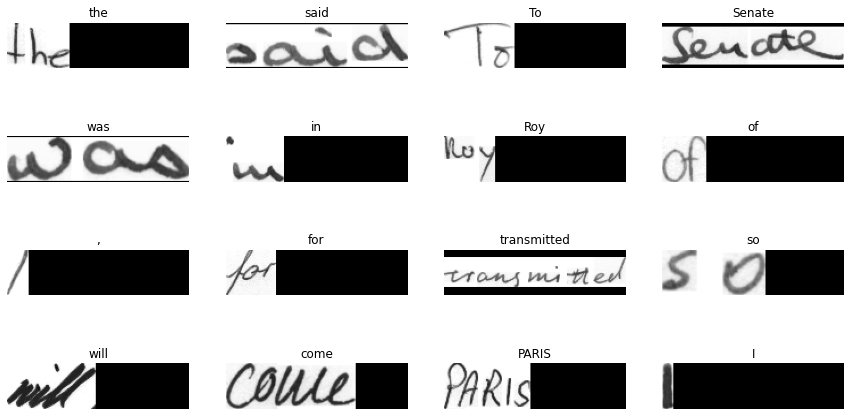

In [ ]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")


plt.show()

You will notice that the content of original image is kept as faithful as possible and has
been padded accordingly.

##8. The output sequence from the output layer will be fed to the CTC layer..

In [ ]:
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred

##7. Create a model for training:
a) Add several CNN layers to extract the sequence of features

b) Add Bi-LSTM layers to propagate through the sequence

c) Add a dense layer (output layer) with total number of neurons as (total number of characters + 1) and the activation as softmax.

In [ ]:
def build_model():
    # Inputs to the model
    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # First conv block.
    x = keras.layers.Conv2D(40,(3, 3),
                            activation="relu",
                            kernel_initializer="he_normal",
                            padding="same",
                            name="Conv1",
                            )(input_img)

    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block.
    x = keras.layers.Conv2D(80,(3, 3),
                            activation="relu",
                            kernel_initializer="he_normal",
                            padding="same",
                            name="Conv2",
                            )(x)

    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    new_shape = ((image_width // 4), (image_height // 4) * 80)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(80, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)

    # RNNs.
    x = keras.layers.Bidirectional(keras.layers.LSTM(160, return_sequences=True, dropout=0.25))(x)
    x = keras.layers.Bidirectional(keras.layers.LSTM(80, return_sequences=True, dropout=0.25))(x)

    # +2 is to account for the two special tokens introduced by the CTC loss.

    x = keras.layers.Dense(len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2")(x)

    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model.
    model = keras.models.Model(inputs=[input_img, labels], outputs=output, name="HW_Recognizer")
    # Optimizer.
    opt = keras.optimizers.Adam()
    # Compile the model and return.
    model.compile(optimizer=opt)
    return model

# Get the model.
model = build_model()
model.summary()

Model: "HW_Recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 160, 40, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 160, 40, 40)  400         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 80, 20, 40)   0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 80, 20, 80)   28880       ['pool1[0][0]']      

In [ ]:
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

Now, we create a callback to monitor the edit distances.

In [ ]:
def calculate_edit_distance(labels, predictions):
    # Get a single batch and convert its labels to sparse tensors.
    saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.backend.ctc_decode(predictions, input_length=input_len, greedy=True)[0][0][:, :max_len]
    sparse_predictions = tf.cast(tf.sparse.from_dense(predictions_decoded), dtype=tf.int64)

    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(sparse_predictions, saprse_labels, normalize=False)
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}")


## Training

Now we are ready to kick off model training.

In [ ]:
epochs = 50  # To get good results this should be at least 50.

model = build_model()
prediction_model = keras.models.Model(model.get_layer(name="image").input, model.get_layer(name="dense2").output)
edit_distance_callback = EditDistanceCallback(prediction_model)

# Train the model.
history = model.fit(
                    train_ds,
                    validation_data=validation_ds,
                    epochs=epochs,
                    callbacks=[edit_distance_callback],
                    )

Epoch 1/50
200/200 [==============================] - 50s 165ms/step - loss: 18.8429 - val_loss: 15.3775
Epoch 2/50
200/200 [==============================] - 31s 153ms/step - loss: 14.8403 - val_loss: 14.5336
Epoch 3/50
200/200 [==============================] - 27s 135ms/step - loss: 14.1967 - val_loss: 14.0982
Epoch 4/50
200/200 [==============================] - 27s 136ms/step - loss: 13.8101 - val_loss: 13.7116
Epoch 5/50
200/200 [==============================] - 27s 134ms/step - loss: 13.3595 - val_loss: 13.3124
Epoch 6/50
200/200 [==============================] - 27s 134ms/step - loss: 12.8267 - val_loss: 12.6308
Epoch 7/50
200/200 [==============================] - 27s 137ms/step - loss: 12.2937 - val_loss: 12.1339
Epoch 8/50
200/200 [==============================] - 27s 134ms/step - loss: 11.7041 - val_loss: 11.4533
Epoch 9/50
200/200 [==============================] - 26s 132ms/step - loss: 11.1938 - val_loss: 11.1648
Epoch 10/50
200/200 [==============================] - 

## Inference

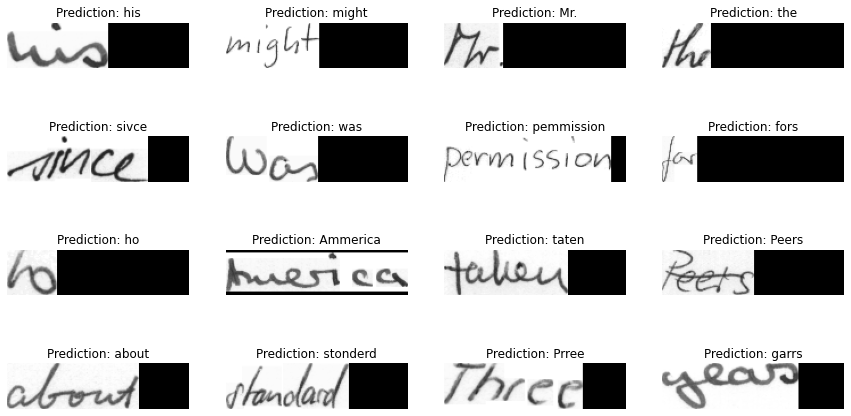

In [ ]:
# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some test samples.
for batch in test_ds.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()

In [ ]:
model.save_weights('hw_recogniser.h5')